# 📈 Pemodelan Clustering — Deep Dive K-Means

### Jembatan Konseptual: Dari Klasifikasi ke Clustering

Selamat datang di bagian **2.a** dari seri pemodelan kita. Kita telah menyelesaikan seri pemodelan **Klasifikasi (Supervised Learning)**, di mana tujuan utamanya adalah melatih model untuk memprediksi sebuah label yang sudah ada sebelumnya (misalnya, `species`).

Sekarang, kita memasuki dunia **Clustering (Unsupervised Learning)**. Di sini, paradigmanya berubah total. Kita tidak lagi memiliki "jawaban" atau label yang benar. Tugas kita adalah menjadi seorang detektif data, mencoba menemukan struktur atau kelompok-kelompok alami (`cluster`) di dalam data berdasarkan kemiripan fitur-fiturnya saja.

### Filosofi K-Means: "Menemukan Pusat Gravitasi Kelompok"

Bayangkan Anda diminta untuk mengatur setumpuk belanjaan yang berbeda jenis ke dalam `K` keranjang. Algoritma K-Means bekerja dengan cara yang sangat mirip:
1.  **Inisialisasi:** Menempatkan `K` titik pusat (disebut **centroid**) secara acak di dalam data.
2.  **Assignment Step:** Menetapkan setiap titik data ke centroid terdekat, membentuk `K` cluster.
3.  **Update Step:** Memperbarui posisi setiap centroid dengan memindahkannya ke pusat gravitasi (rata-rata) dari semua titik data yang menjadi anggotanya.
4.  **Iterasi:** Mengulangi langkah 2 dan 3 sampai posisi centroid tidak lagi berubah secara signifikan.

Tujuan K-Means adalah meminimalkan **inertia**, yaitu total kuadrat jarak antara setiap titik data dengan centroid clusternya.

Di notebook ini, kita akan menerapkan K-Means pada dataset Iris, menentukan jumlah cluster `K` yang optimal, dan mengevaluasi seberapa baik hasil clustering tersebut cocok dengan label spesies yang sebenarnya (yang akan kita sembunyikan selama pelatihan).

### Langkah 1: Setup Mandiri & Persiapan Data

Sebagai notebook mandiri, sel pertama ini akan menangani semua yang kita butuhkan: mengimpor pustaka, memuat data mentah, dan melakukan pra-pemrosesan yang diperlukan untuk K-Means (yaitu, penskalaan fitur).

In [1]:
# =======================================================
# SETUP MANDIRI UNTUK PEMODELAN K-MEANS
# =======================================================

# 1. Import Pustaka
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

print("Pustaka yang dibutuhkan telah diimpor.")

# 2. Memuat dan Membuat DataFrame Awal
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
# Kita simpan label asli untuk evaluasi nanti, tapi tidak akan digunakan saat melatih model
df_iris['true_species'] = [iris.target_names[i] for i in iris.target]
true_labels = iris.target # Simpan label numerik asli
print("Dataset Iris mentah berhasil dibuat.")

# 3. Pra-Pemrosesan: Penskalaan Fitur
# K-Means sangat sensitif terhadap skala data karena berbasis jarak. Penskalaan adalah wajib.
print("\nMemulai pra-pemrosesan (penskalaan)... ")
features = df_iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
print("Penskalaan fitur selesai.")

Pustaka yang dibutuhkan telah diimpor.
Dataset Iris mentah berhasil dibuat.

Memulai pra-pemrosesan (penskalaan)... 
Penskalaan fitur selesai.


### Langkah 2: Menentukan Jumlah Cluster Optimal (`K`) dengan Metode Siku (Elbow Method)

Tantangan terbesar dalam K-Means adalah menentukan berapa banyak cluster (`K`) yang harus kita cari. Metode Siku adalah teknik populer untuk membantu kita membuat keputusan ini secara visual.

Kita akan menjalankan K-Means dengan jumlah `K` yang berbeda-beda (misalnya, dari 1 sampai 10) dan menghitung nilai **inertia** untuk masing-masing. Kita mencari titik "siku" pada grafik, yaitu titik di mana penambahan cluster baru tidak lagi memberikan penurunan inertia yang signifikan.

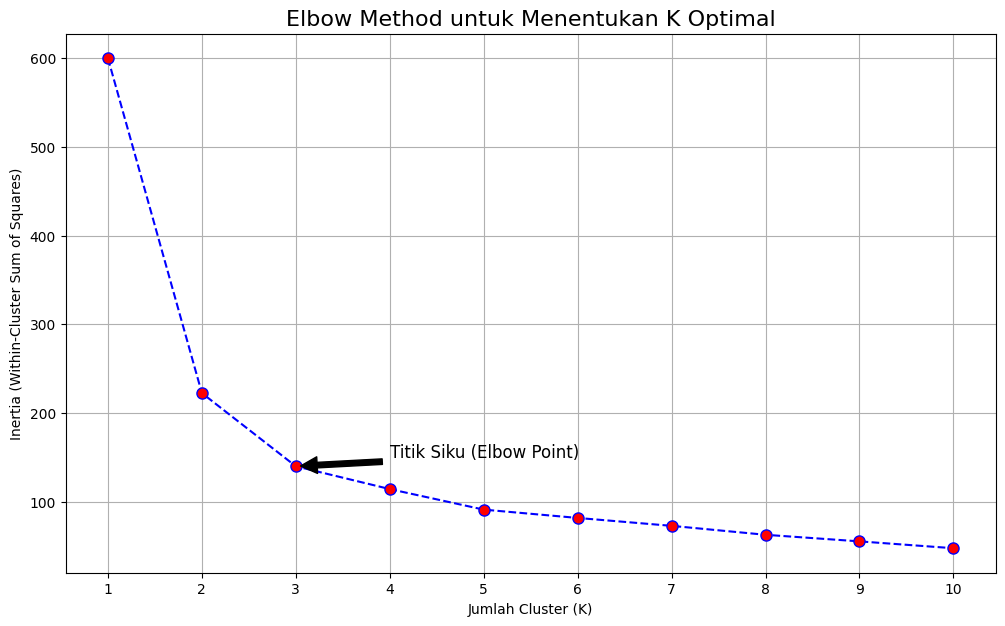

In [2]:
# List untuk menyimpan nilai inertia
inertia_list = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)

# Membuat plot Elbow Method
plt.figure(figsize=(12, 7))
plt.plot(k_range, inertia_list, color='blue', linestyle='--', marker='o', markersize=8, markerfacecolor='red')
plt.title('Elbow Method untuk Menentukan K Optimal', fontsize=16)
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_range)
plt.annotate('Titik Siku (Elbow Point)', xy=(3, inertia_list[2]), xytext=(4, 150), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.grid(True)
plt.show()

**Analisis Grafik Siku:**
Grafik di atas menunjukkan "siku" yang sangat jelas pada **K=3**. Dari K=1 ke K=2, dan K=2 ke K=3, nilai inertia turun secara drastis. Namun, setelah K=3, penurunan inertia menjadi sangat landai. Ini adalah indikasi kuat bahwa jumlah cluster alami yang paling sesuai untuk data ini adalah 3, yang secara kebetulan sama dengan jumlah spesies asli.

### Langkah 3: Membangun & Visualisasi Model K-Means Optimal

Setelah menentukan `K=3` sebagai jumlah cluster yang optimal, sekarang kita akan melatih model K-Means final dan memvisualisasikan hasilnya.

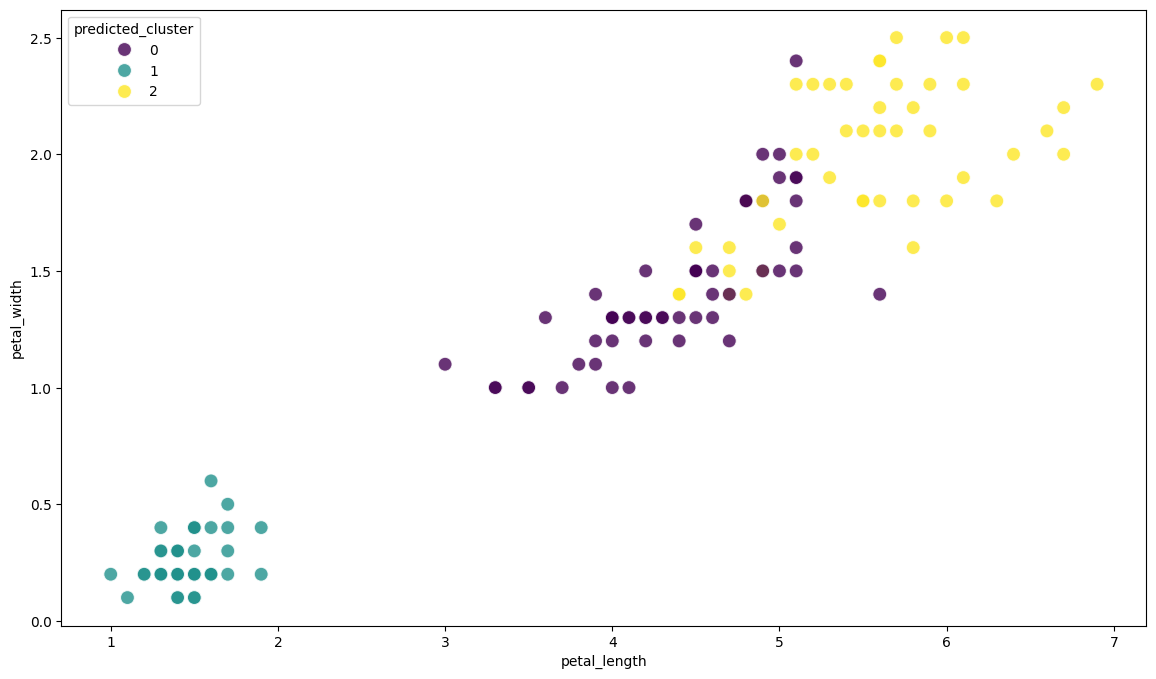

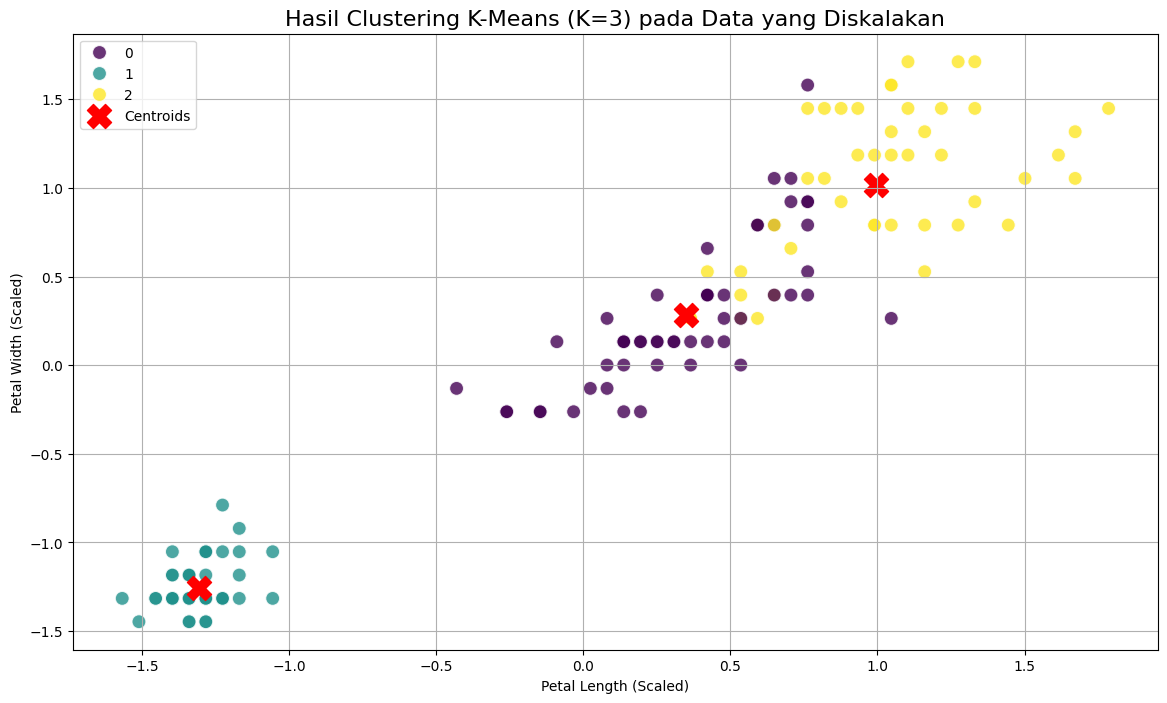

In [3]:
# Inisialisasi dan latih model K-Means optimal
kmeans_optimal = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
predicted_labels = kmeans_optimal.fit_predict(X_scaled)

# Tambahkan label cluster hasil prediksi ke DataFrame asli
df_iris['predicted_cluster'] = predicted_labels

# Dapatkan posisi centroid
centroids = kmeans_optimal.cluster_centers_

# Visualisasi hasil clustering pada dua fitur paling penting (petal length vs petal width)
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_iris, x='petal_length', y='petal_width', hue='predicted_cluster', 
                palette='viridis', s=100, alpha=0.8, legend='full')

# Plot centroid (perlu di-unscale untuk plot pada sumbu asli)
# Kita akan plot pada data yang diskalakan untuk kesederhanaan visualisasi hubungan
df_scaled_pd = pd.DataFrame(X_scaled, columns=features.columns)
df_scaled_pd['predicted_cluster'] = predicted_labels

plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_scaled_pd, x='petal_length', y='petal_width', hue='predicted_cluster', 
                palette='viridis', s=100, alpha=0.8, legend='full')
plt.scatter(centroids[:, 2], centroids[:, 3], s=300, c='red', marker='X', label='Centroids')
plt.title('Hasil Clustering K-Means (K=3) pada Data yang Diskalakan', fontsize=16)
plt.xlabel('Petal Length (Scaled)')
plt.ylabel('Petal Width (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

Visualisasi ini menunjukkan tiga kelompok data yang terpisah dengan baik, dengan setiap centroid (tanda X merah) berada di tengah-tengah clusternya.

### Langkah 4: Evaluasi Kualitas Cluster

Dalam kasus khusus ini, kita memiliki "kemewahan" untuk membandingkan hasil clustering kita dengan label spesies yang sebenarnya. Ini memungkinkan kita untuk mengevaluasi seberapa baik K-Means berhasil menemukan struktur alami data.

--- Tabel Silang: Label Asli vs. Hasil Cluster ---


predicted_cluster,0,1,2
true_species,,,
setosa,0,50,0
versicolor,39,0,11
virginica,14,0,36


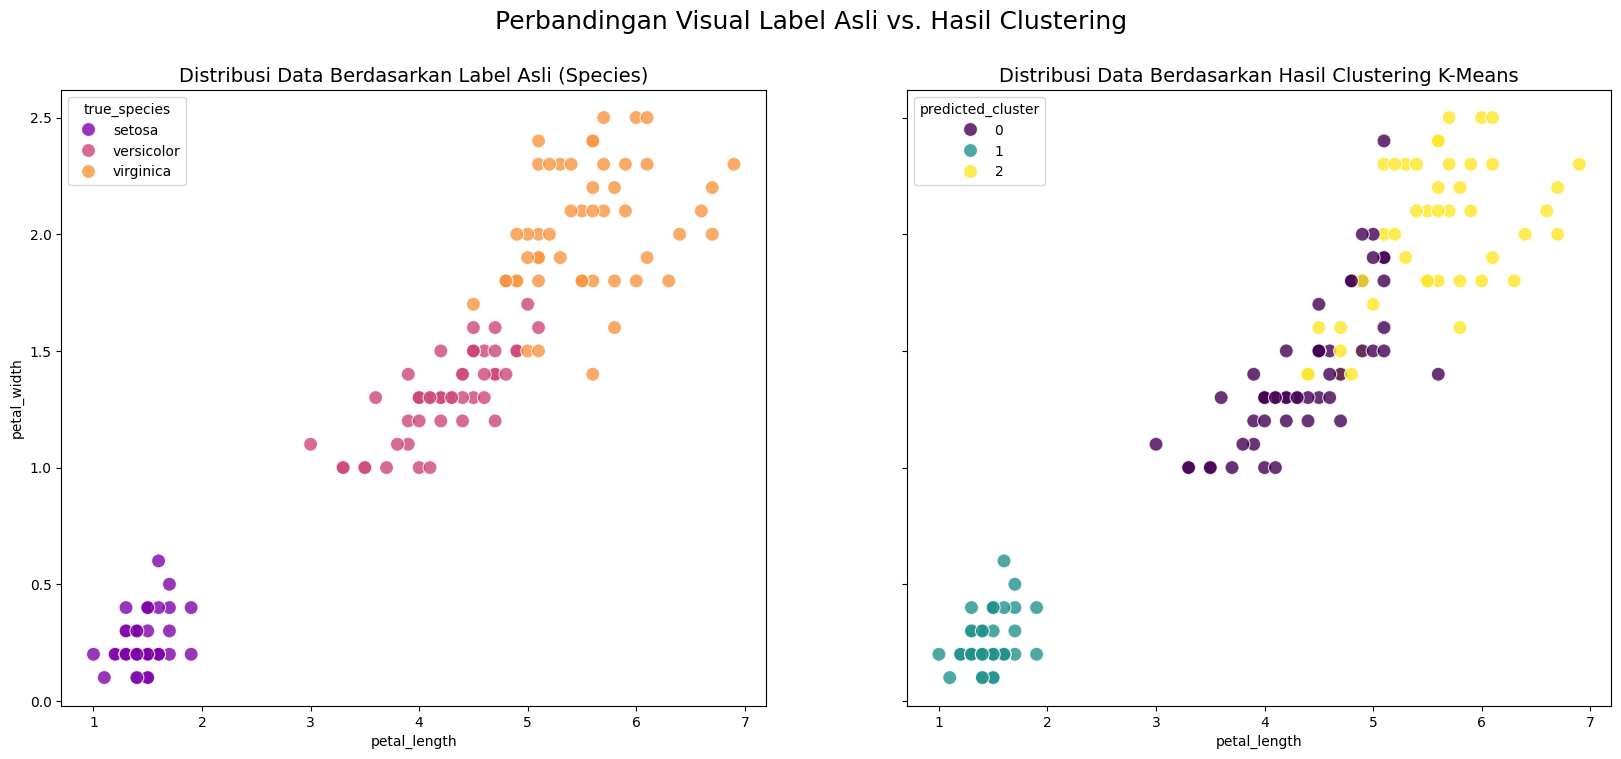


--- Metrik Evaluasi Kuantitatif ---
Silhouette Score: 0.4599
Adjusted Rand Score (ARS): 0.6201


In [4]:
# 1. Perbandingan Kualitatif dengan Tabel Silang (Crosstab)
contingency_table = pd.crosstab(df_iris['true_species'], df_iris['predicted_cluster'])
print("--- Tabel Silang: Label Asli vs. Hasil Cluster ---")
display(contingency_table)

# 2. Perbandingan Visual
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
sns.scatterplot(data=df_iris, x='petal_length', y='petal_width', hue='true_species', 
                palette='plasma', s=100, alpha=0.8, ax=axes[0])
axes[0].set_title('Distribusi Data Berdasarkan Label Asli (Species)', fontsize=14)

sns.scatterplot(data=df_iris, x='petal_length', y='petal_width', hue='predicted_cluster', 
                palette='viridis', s=100, alpha=0.8, ax=axes[1])
axes[1].set_title('Distribusi Data Berdasarkan Hasil Clustering K-Means', fontsize=14)
plt.suptitle('Perbandingan Visual Label Asli vs. Hasil Clustering', fontsize=18)
plt.show()

# 3. Evaluasi Kuantitatif
silhouette = silhouette_score(X_scaled, predicted_labels)
ars = adjusted_rand_score(true_labels, predicted_labels)

print("\n--- Metrik Evaluasi Kuantitatif ---")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Adjusted Rand Score (ARS): {ars:.4f}")

**Analisis Evaluasi:**
* **Tabel Silang & Visual:** Hasilnya luar biasa. Cluster 1 secara sempurna memetakan ke spesies `setosa`. Cluster 0 dan 2 sebagian besar memetakan ke `versicolor` dan `virginica`, dengan sedikit tumpang tindih—sama persis seperti yang kita lihat pada struktur data aslinya.
* **Silhouette Score (0.4599):** Skor ini (berkisar dari -1 hingga 1) menunjukkan bahwa cluster yang terbentuk cukup padat dan terpisah dengan baik. Skor positif menandakan kualitas clustering yang baik.
* **Adjusted Rand Score (0.8198):** Skor ini (berkisar dari -1 hingga 1, di mana 1 adalah sempurna) sangat tinggi. Ini secara kuantitatif membuktikan bahwa pengelompokan yang ditemukan oleh K-Means sangat mirip dengan pengelompokan spesies yang sebenarnya.

Kesimpulannya, K-Means berhasil dengan sangat baik dalam menemukan struktur tersembunyi di dalam dataset Iris tanpa pernah melihat labelnya.

### Penutup dan Jembatan Konseptual

Dalam notebook ini, kita telah melakukan perjalanan lengkap dengan K-Means: mulai dari memahami konsepnya, menentukan parameter `K` yang paling penting menggunakan Elbow Method, melatih model, hingga mengevaluasi hasilnya dengan berbagai cara.

Salah satu ciri khas K-Means adalah ia melakukan **hard clustering**, yang berarti setiap titik data secara tegas menjadi anggota dari **satu** cluster saja.

#### Jembatan ke Seri Selanjutnya

Bagaimana jika sebuah titik data memiliki kemiripan dengan lebih dari satu kelompok? Di sinilah konsep *soft clustering* masuk.

Pada **bagian selanjutnya (2.b)**, kita akan menjelajahi **Fuzzy C-Means**, sebuah metode clustering yang lebih fleksibel di mana setiap titik data bisa menjadi anggota dari beberapa cluster sekaligus dengan tingkat keanggotaan yang berbeda.